<a href="https://colab.research.google.com/github/Farhana-Najnin/ChurnBuster/blob/main/ChurnBuster(Customer_Churn_Prediction_%26_Retention_Dashboard).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============Final=================
# 1) Install dependencies
# ================================
!pip -q install -U pyngrok python-dotenv xgboost shap streamlit scikit-learn pandas numpy matplotlib

import os
import textwrap
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from pyngrok import ngrok, conf

In [ ]:
# ================================
# 2) Load .env and hide token (ONLY CHANGE)
# ================================
load_dotenv()  # loads .env automatically

NGROK_AUTHTOKEN = os.getenv("NGROK_AUTH_TOKEN")

if not NGROK_AUTHTOKEN:
    raise ValueError("NGROK_AUTH_TOKEN not found in .env file")
#print(NGROK_AUTHTOKEN)

In [ ]:
# ================================
# 3) ngrok v3 FIX (UNCHANGED)
# ================================
cfg = conf.PyngrokConfig(ngrok_version="v3")

ngrok.set_auth_token(NGROK_AUTHTOKEN, pyngrok_config=cfg)

try:
    ngrok.kill(pyngrok_config=cfg)
except Exception:
    pass


In [ ]:
# ================================
# 3) Load dataset (same functionality)
# ================================
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dataset Shape:", df.shape)
df.head()



Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop(["Churn", "customerID"], axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

/tmp/ipython-input-3819040322.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Scale pos weight:", scale_pos_weight)

Scale pos weight: 2.768561872909699


In [ ]:
model = xgb.XGBClassifier(
    n_estimators=350,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.85
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print("ROC-AUC Score:", round(roc_auc_score(y_test, y_prob), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



ROC-AUC Score: 0.836

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.75      0.76      1409



Optimal threshold: 0.1

Classification Report at Optimal Threshold:

              precision    recall  f1-score   support

           0       0.96      0.43      0.60      1035
           1       0.38      0.95      0.54       374

    accuracy                           0.57      1409
   macro avg       0.67      0.69      0.57      1409
weighted avg       0.81      0.57      0.58      1409



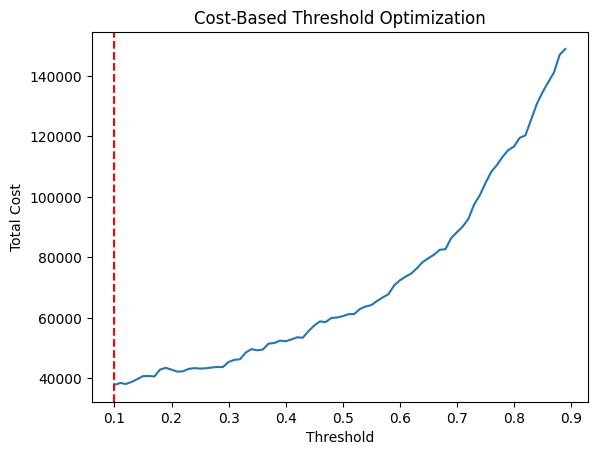

In [ ]:
# ================================
# 4) Cost-based threshold optimization (same functionality)
# ================================
COST_FN = 500
COST_FP = 50

thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    y_t = (y_prob >= t).astype(int)
    fp = ((y_t == 1) & (y_test == 0)).sum()
    fn = ((y_t == 0) & (y_test == 1)).sum()
    costs.append(fp * COST_FP + fn * COST_FN)

optimal_threshold = thresholds[np.argmin(costs)]
print("Optimal threshold:", round(optimal_threshold, 2))

y_opt = (y_prob >= optimal_threshold).astype(int)
print("\nClassification Report at Optimal Threshold:\n")
print(classification_report(y_test, y_opt))

plt.plot(thresholds, costs)
plt.axvline(optimal_threshold, color='red', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost-Based Threshold Optimization")
plt.show()

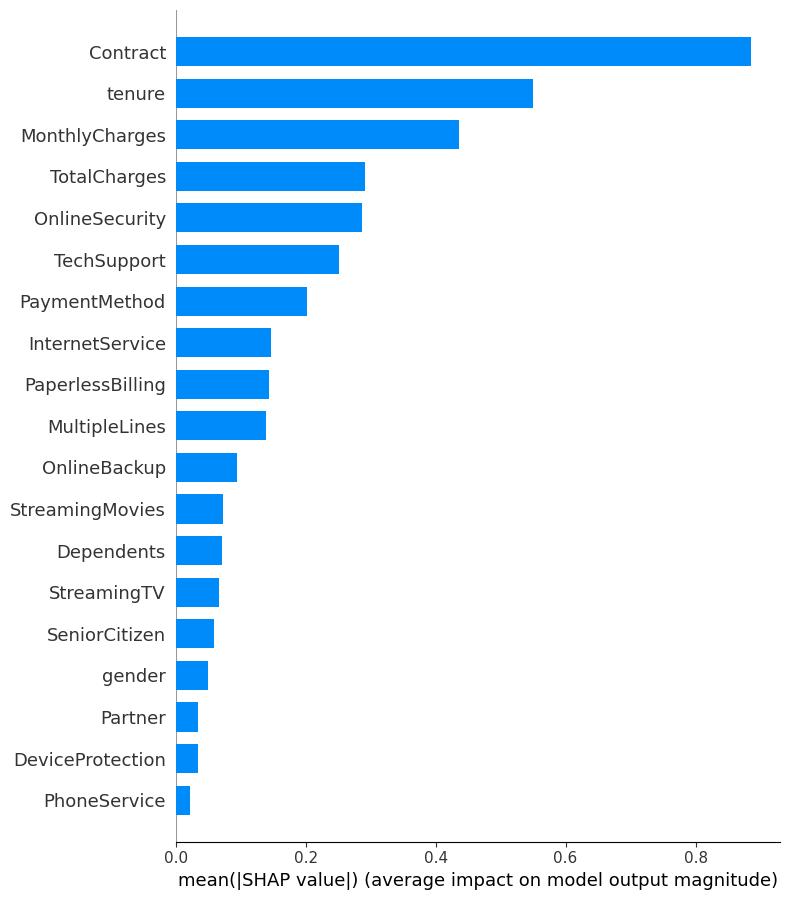

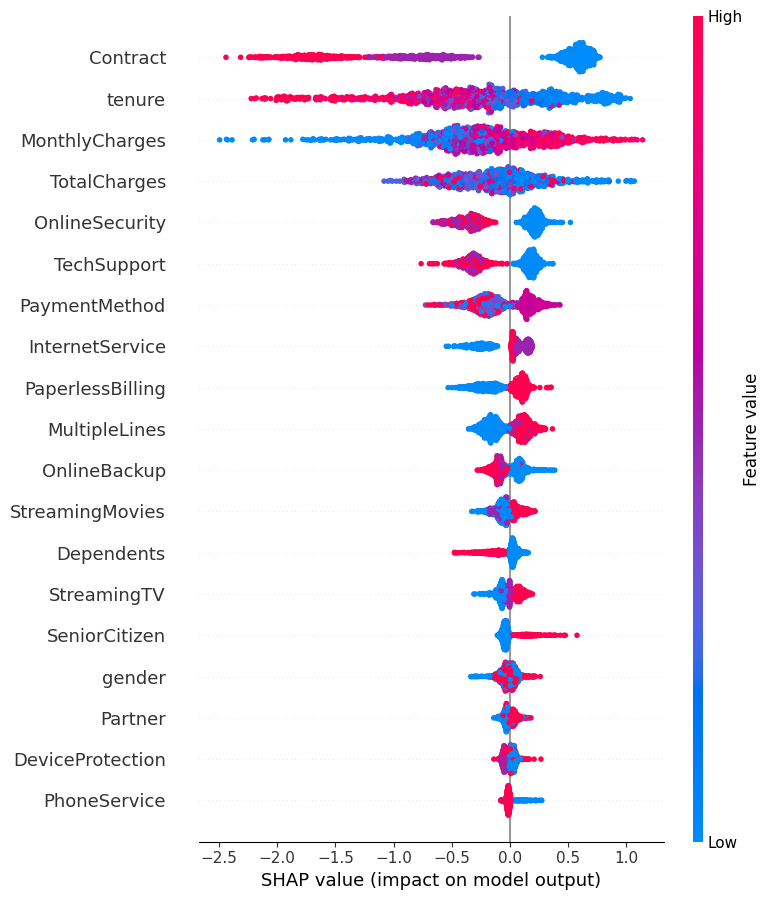

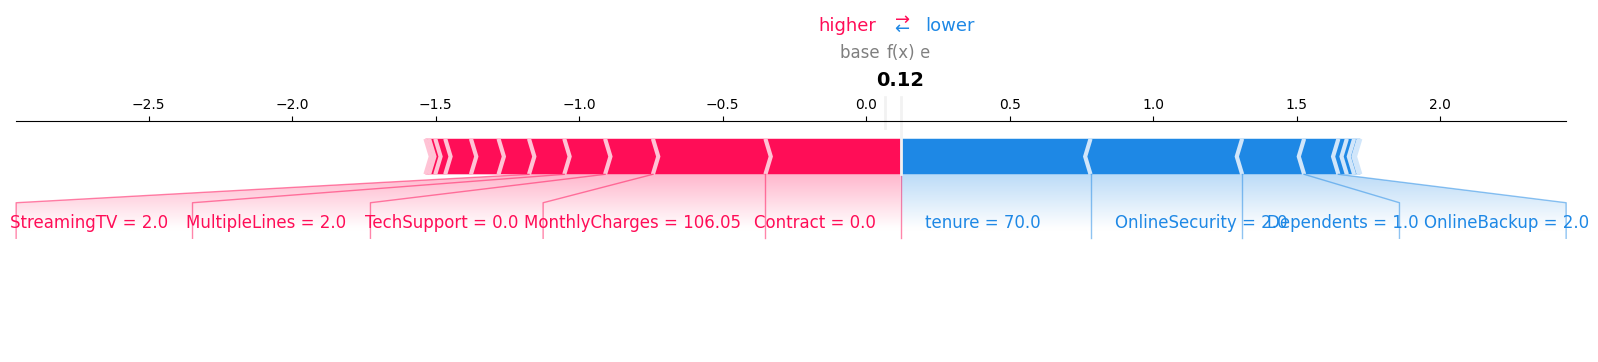

In [ ]:
# ================================
# 5) SHAP explainability (same functionality)
# ================================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary
shap.summary_plot(shap_values, X_test)

# Individual customer
idx = 10
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test.iloc[idx],
    matplotlib=True
)


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

st.set_page_config(page_title="Customer Churn Dashboard", layout="wide")
st.title("📉 Customer Churn Prediction Dashboard")

df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
X = df.drop(["Churn", "customerID"], axis=1)
y = df["Churn"]

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric="auc"
)

model.fit(X, y)
df["Churn_Probability"] = model.predict_proba(X)[:, 1]

threshold = st.slider("Churn Risk Threshold", 0.1, 0.9, 0.4)
df["High_Risk"] = df["Churn_Probability"] >= threshold

st.metric("Total Customers", len(df))
st.metric("High-Risk Customers", int(df["High_Risk"].sum()))

st.dataframe(
    df[df["High_Risk"]]
    .sort_values("Churn_Probability", ascending=False)
    .head(20)
)

Overwriting app.py


In [ ]:
get_ipython().system_raw(
    "streamlit run app.py --server.port 8501 --server.address 0.0.0.0 &"
)

public_url = ngrok.connect(addr=8501, proto="http", pyngrok_config=cfg)
print("Your Streamlit Dashboard URL:", public_url.public_url)

Your Streamlit Dashboard URL: https://endurable-thwartedly-somer.ngrok-free.dev
